# Pipeline 1: Predicting Volatility and Evaluation

In [ ]:
import os
import time
import random
import warnings
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import src.util as util
import src.rv as rv
import src.lstm as lstm

# Suppress warnings
warnings.filterwarnings("ignore")

# Reload modules to pick up any changes
importlib.reload(util)
importlib.reload(rv)
importlib.reload(lstm)

# Set random seed for reproducibility
SEED = 3888
np.random.seed(SEED)
random.seed(SEED)

# set seed for lstm
tf.random.set_seed(SEED)

In [25]:
# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Filter one stock for now
df_single_stock = combined_df[combined_df["stock_id"] == 50200].copy()

# Step 1: Compute snapshot features
snapshot_features_df = util.create_snapshot_features(df_single_stock)
snapshot_features_df = snapshot_features_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

In [ ]:
# select only the first 100 time_id
subset_time_ids = snapshot_features_df['time_id'].unique()[:100]
subset_snapshot_df = snapshot_features_df[snapshot_features_df['time_id'].isin(subset_time_ids)].copy()

In [27]:
importlib.reload(util)
#  Step 2: Compute rolling-window training set
rolling_features_df = util.generate_rolling_features(subset_snapshot_df)

## RV OLS Baseline

=== HAR-RV OLS Baseline Evaluation ===
MSE: 0.00000000
RMSE: 0.00003585
QLIKE: 0.3222
Directional Accuracy: 0.5180
Average inference time per sample: 0.000040 seconds
✅ Model saved to out/rv/rv_ols.pkl


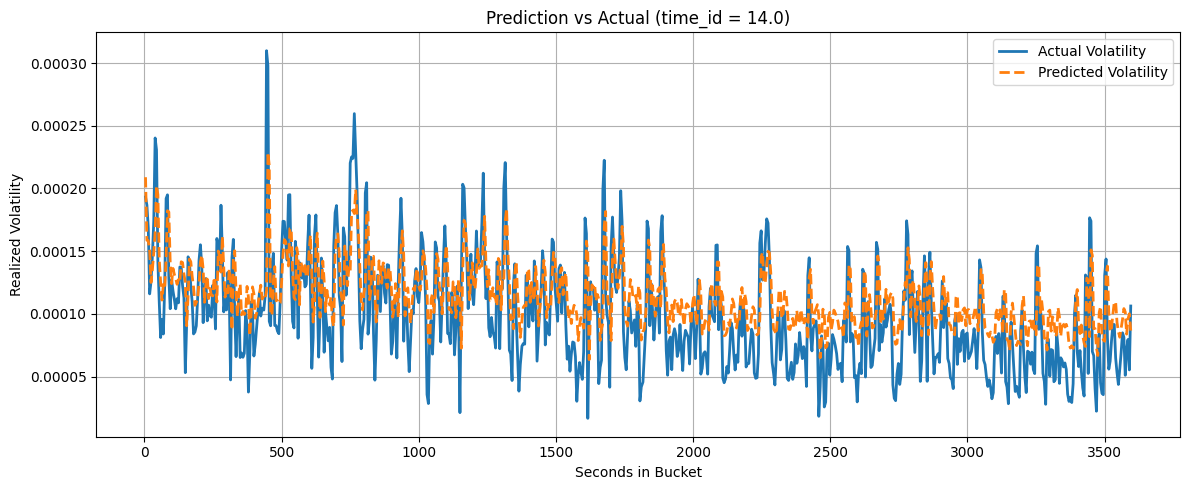

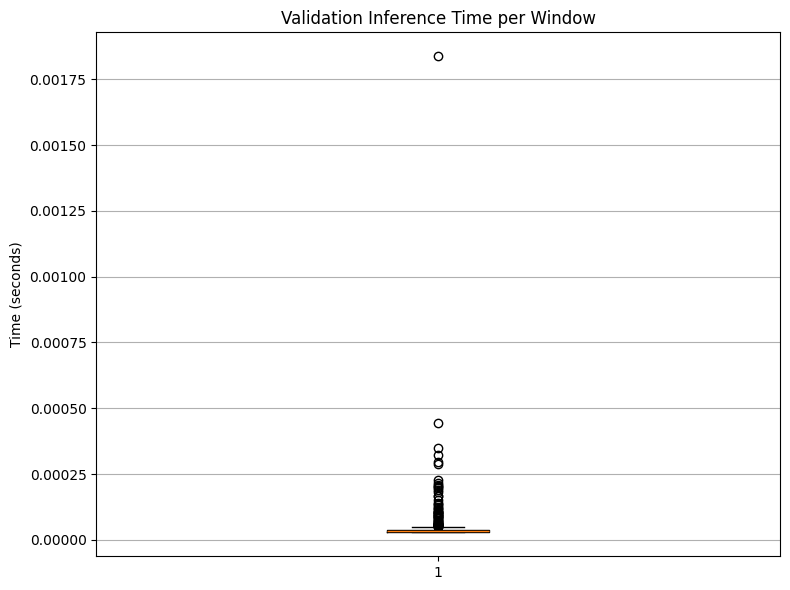

,time_id,start_time,y_true,y_pred,inference_time
0,14.0,4.0,0.000193,0.000209,0.000090
1,14.0,9.0,0.000187,0.000159,0.000064
2,14.0,14.0,0.000169,0.000158,0.000055
3,14.0,19.0,0.000116,0.000150,0.000053
4,14.0,24.0,0.000126,0.000125,0.000053
5,14.0,29.0,0.000146,0.000135,0.000052
6,14.0,34.0,0.000174,0.000149,0.000072
7,14.0,39.0,0.000240,0.000165,0.000051
8,14.0,44.0,0.000231,0.000202,0.000050
9,14.0,49.0,0.000141,0.000195,0.000050


In [53]:
# OLS Model

# Import and reload HAR-RV model
# import function from models/har_rv.py
import p1.rv as rv
importlib.reload(rv)

model_rv_ols, test_df_ols = rv.ols(rolling_features_df)

# Plot predicted vs. actual volatility for one time_id
util.plot_prediction_vs_actual(
    df=test_df_ols,
    time_id=test_df_ols['time_id'].iloc[0],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(test_df_ols)

display(test_df_ols.head(10))

## LSTM

### LSTM Baseline

In [ ]:
import p1.lstm as lstm
importlib.reload(lstm)

# --- Run LSTM Baseline ---
model_lstm_baseline, history_lstm_baseline, val_df_lstm_baseline = lstm.baseline(
    snapshot_df=subset_snapshot_df,
    basic_features=['wap', 'log_return'],
    epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    es_patience=10,
    lr_patience=5,
    model_name='baseline'
)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.9670 - val_loss: 0.8451 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.9312 - val_loss: 0.9084 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.8604 - val_loss: 0.7321 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.8056 - val_loss: 0.5870 - learning_rate: 1.0000e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7540 - val_loss: 0.5282 - learning_rate: 1.0000e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7424 - val_loss: 0.5096 - learning_rate: 1.0000e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7383 - val_loss: 0.5002 - learning_rate: 1.0000e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7359 - val_loss: 0.4942 - learning_rate: 1.0000e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7343 - val_loss: 

Validation MSE: 0.00000000
Validation RMSE: 0.00004232
Validation QLIKE: 0.3961
Directional Acc: 0.3657
Average inference time per window: 0.032856 seconds
Model & scalers saved to out/lstm


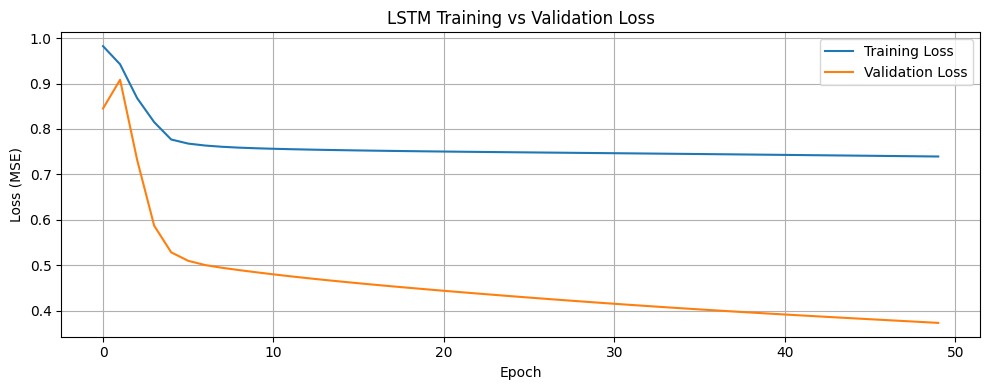

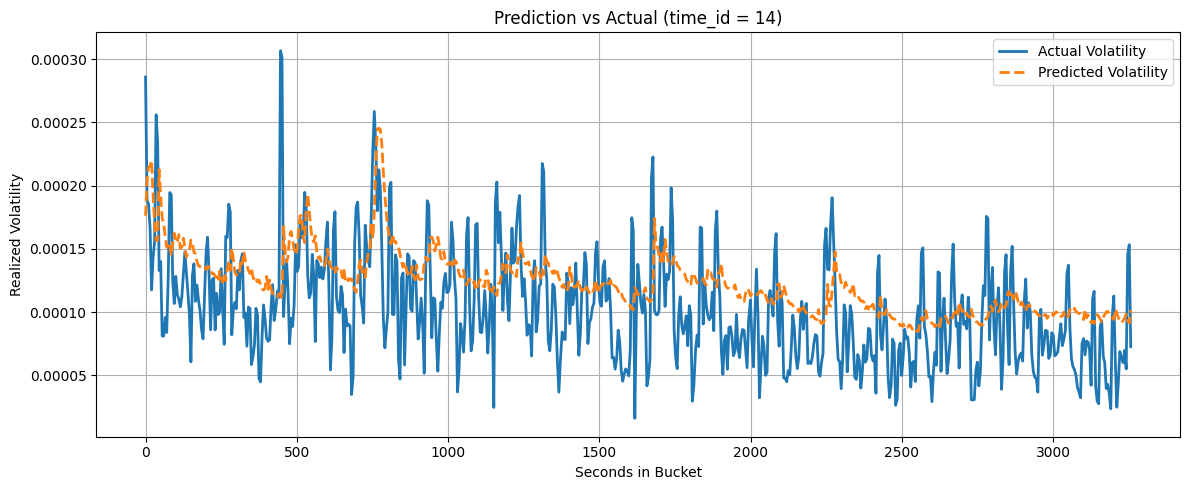

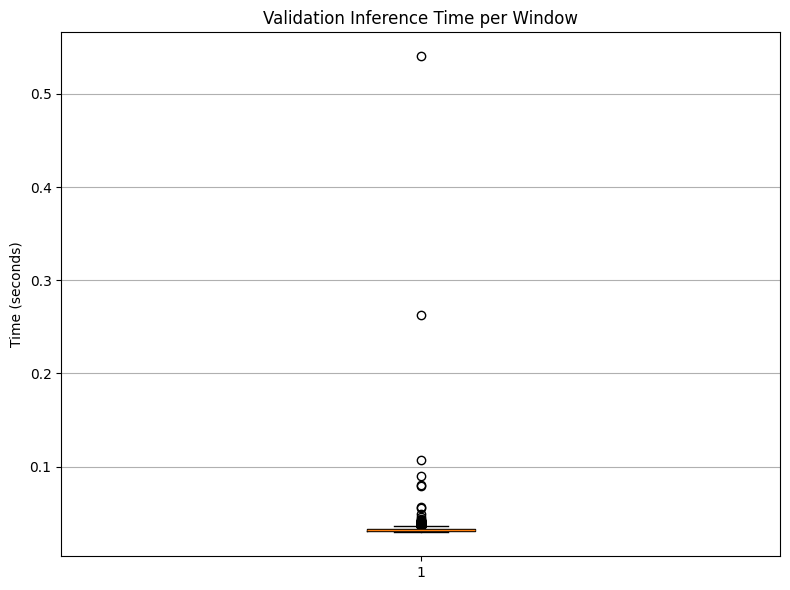

,time_id,start_time,y_true,y_pred,inference_time
0,14,0.0,0.000286,0.000176,0.540559
1,14,5.0,0.000188,0.000205,0.034921
2,14,10.0,0.000185,0.000214,0.035679
3,14,15.0,0.000166,0.000215,0.033417
4,14,20.0,0.000118,0.000220,0.032998
5,14,25.0,0.000144,0.000193,0.034423
6,14,30.0,0.000156,0.000170,0.032971
7,14,35.0,0.000256,0.000157,0.032453
8,14,40.0,0.000234,0.000157,0.034502
9,14,45.0,0.000133,0.000213,0.032566


In [ ]:
# --- Plot training loss ---
util.plot_training_loss(history_lstm_baseline)

# --- Plot prediction vs actual ---
util.plot_prediction_vs_actual(
    val_df_lstm_baseline,
    time_id=val_df_lstm_baseline['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_baseline)

display(val_df_lstm_baseline.head(10))

### LSTM With Features

In [31]:
import p1.lstm as lstm
importlib.reload(lstm)

feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]

# --- Run LSTM Baseline ---
model_lstm_features, history_lstm_features, val_df_lstm_features = lstm.baseline(
    snapshot_df=subset_snapshot_df,
    basic_features=feature_cols,
    epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    es_patience=10,
    lr_patience=5,
    model_name='additional_features'
)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.9404 - val_loss: 0.5201 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.8318 - val_loss: 0.3994 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.8099 - val_loss: 0.3670 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7932 - val_loss: 0.3453 - learning_rate: 1.0000e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.7775 - val_loss: 0.3409 - learning_rate: 1.0000e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7675 - val_loss: 0.3467 - learning_rate: 1.0000e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7612 - val_loss: 0.3495 - learning_rate: 1.0000e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7558 - val_loss: 0.3521 - learning_rate: 1.0000e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7506 - val_loss: 

Validation MSE: 0.00000000
Validation RMSE: 0.00004046
Validation QLIKE: 0.3822
Directional Acc: 0.4228
Average inference time per window: 0.032021 seconds
Model & scalers saved to out/lstm


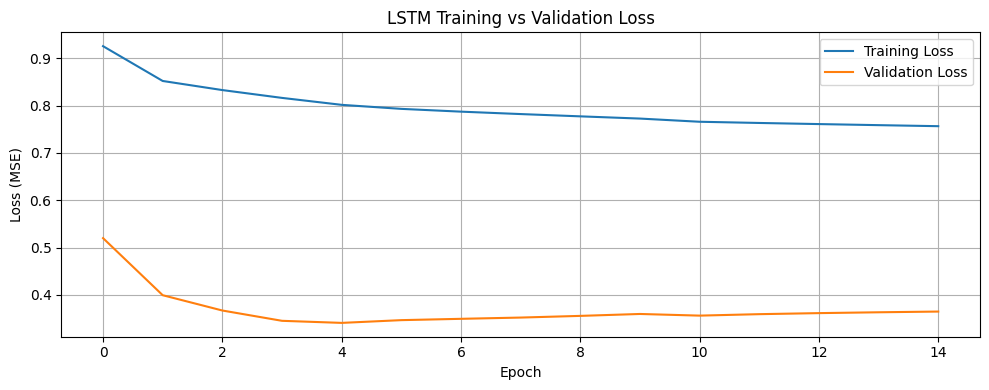

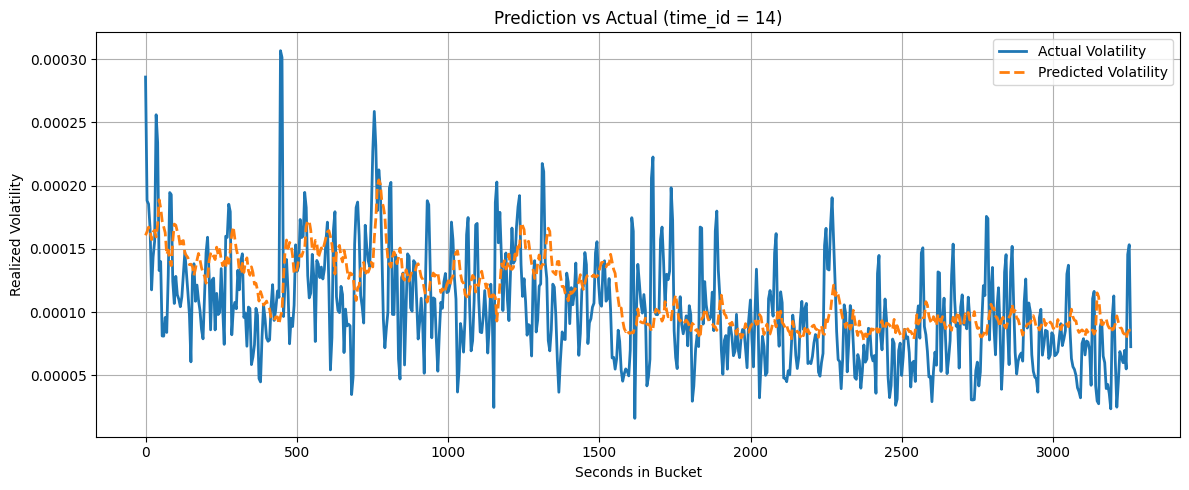

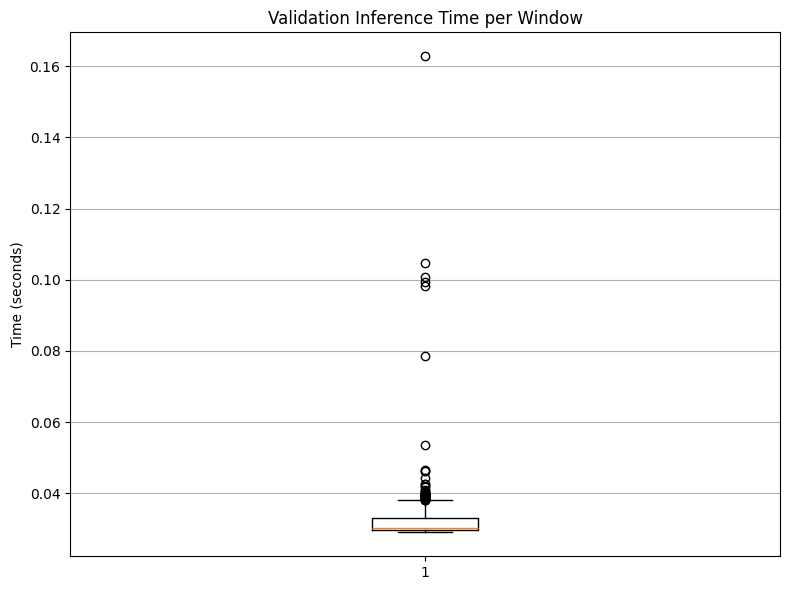

,time_id,start_time,y_true,y_pred,inference_time
0,14,0.0,0.000286,0.000161,0.104821
1,14,5.0,0.000188,0.000164,0.035891
2,14,10.0,0.000185,0.000167,0.035220
3,14,15.0,0.000166,0.000164,0.035258
4,14,20.0,0.000118,0.000157,0.037052
5,14,25.0,0.000144,0.000163,0.035133
6,14,30.0,0.000156,0.000165,0.035833
7,14,35.0,0.000256,0.000159,0.035038
8,14,40.0,0.000234,0.000169,0.038045
9,14,45.0,0.000133,0.000189,0.036456


In [43]:
# --- Plot training loss ---
util.plot_training_loss(history_lstm_features)

# --- Plot prediction vs actual ---
util.plot_prediction_vs_actual(
    val_df_lstm_features,
    time_id=val_df_lstm_features['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_features)

display(val_df_lstm_features.head(10))

## Advanced LSTM Model

In [33]:
import p1.lstm as lstm
importlib.reload(lstm)

feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]

model_lstm_advanced, history_lstm_advanced, val_df_lstm_advanced = lstm.advanced(
    subset_snapshot_df,
    basic_features=feature_cols,
    epochs=50,
    batch_size=32,
    model_name='advanced'
)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - loss: 0.9337 - val_loss: 0.5344 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - loss: 0.9812 - val_loss: 0.6718 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - loss: 1.3151 - val_loss: 0.9286 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - loss: 1.2305 - val_loss: 0.6662 - learning_rate: 1.0000e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 220ms/step - loss: 1.1969 - val_loss: 0.5519 - learning_rate: 1.0000e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 218ms/step - loss: 1.1402 - val_loss: 0.6262 - learning_rate: 1.0000e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 222ms/step - loss: 1.1482 - val_loss: 0.6520 - learning_rate: 1.0000e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step - loss: 1.0906 - val_loss: 0.6414 - learning_rate: 1.0000e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 37s 223ms/step - loss: 1

Final Model MSE: 0.00000000
Final Model RMSE: 0.00005066
Final Model QLIKE: 0.5020
Directional Acc: 0.4699
Avg Inference Time: 0.061351s
Saved final model & scalers to <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_30>


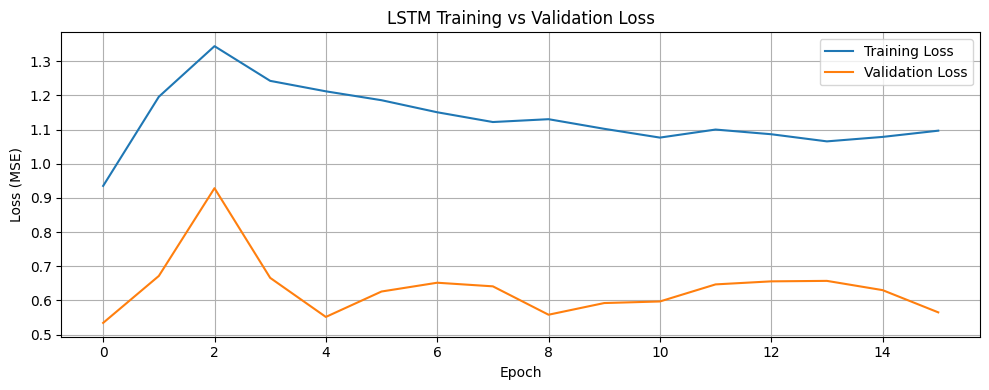

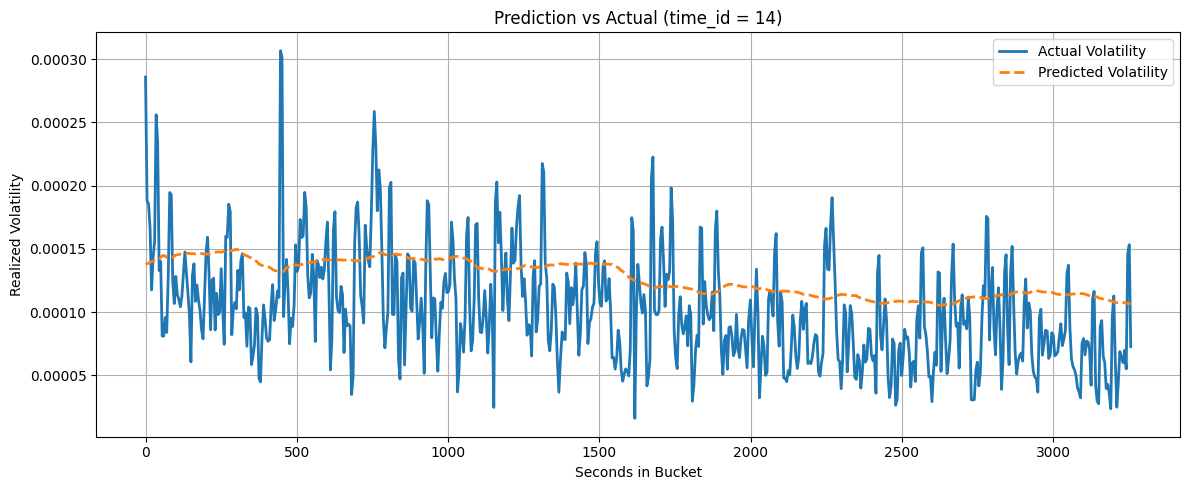

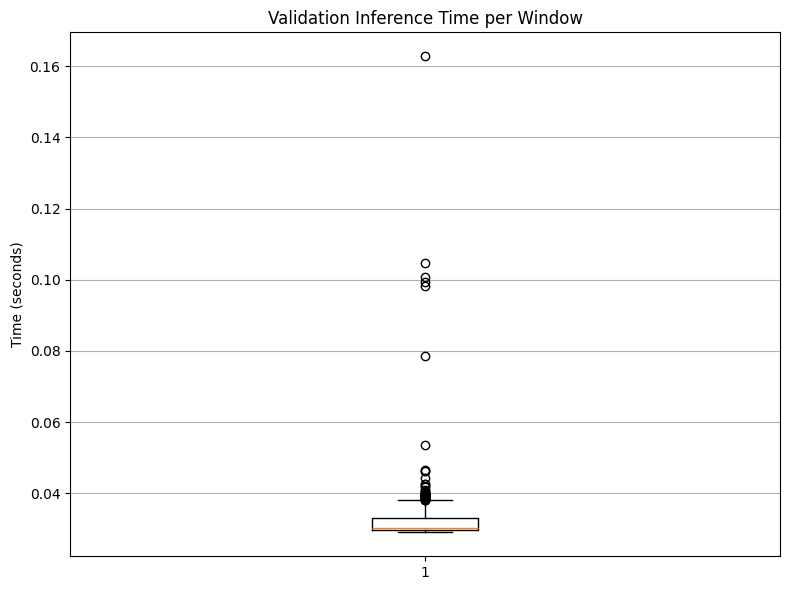

In [34]:
# --- Plot training loss ---
util.plot_training_loss(history_lstm_advanced)

# --- Plot prediction vs actual ---
util.plot_prediction_vs_actual(
    val_df_lstm_advanced,
    time_id=val_df_lstm_advanced['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_features)

## In Sample Evaluation

                      model           mse      rmse     qlike  \
0              ols_baseline  1.285060e-09  0.000036  0.322214   
1             lstm_baseline  1.791092e-09  0.000042  0.396131   
2  lstm_additional_features  1.637124e-09  0.000040  0.382185   
3             lstm_advanced  2.566615e-09  0.000051  0.501960   

   directional_accuracy  avg_inference_time  
0              0.517975            0.000040  
1              0.365741            0.032856  
2              0.422840            0.032021  
3              0.469907            0.061351  


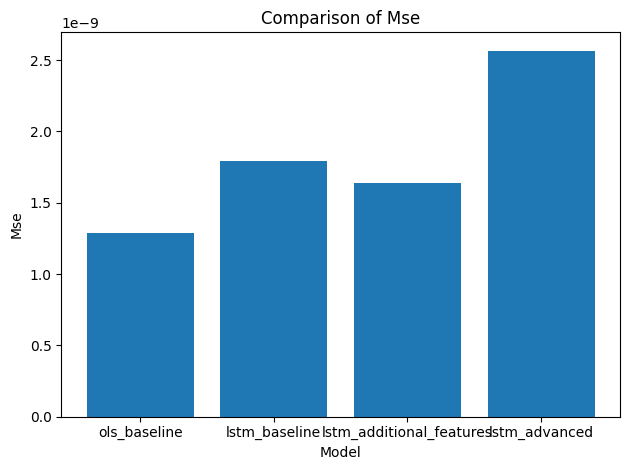

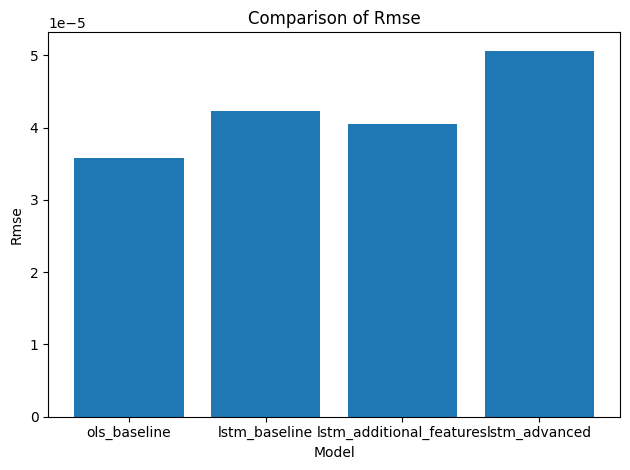

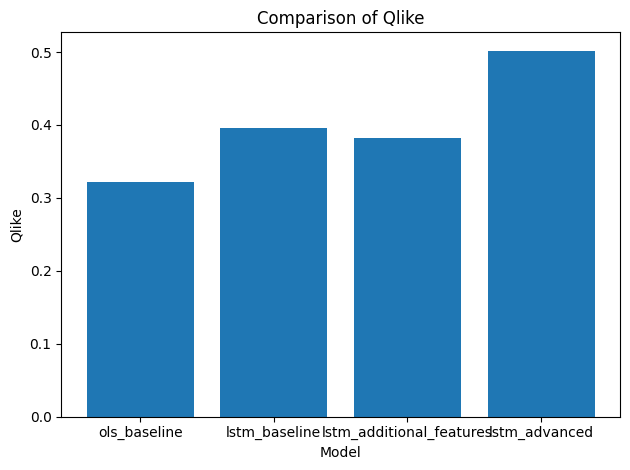

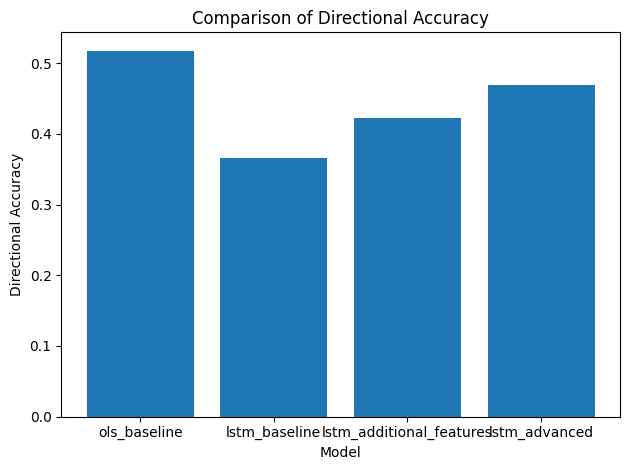

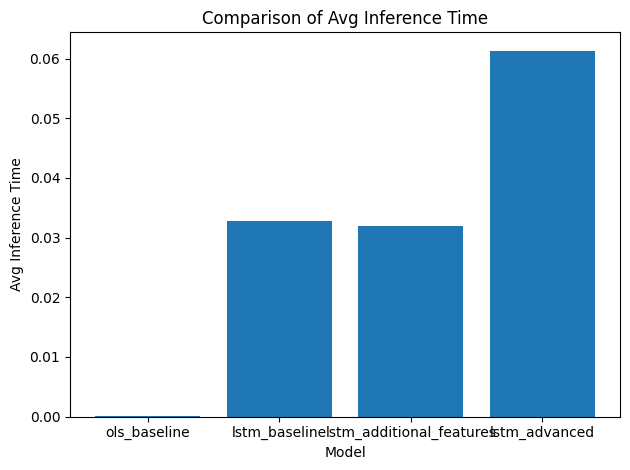

In [ ]:
metrics = []
for name, val_df in [
        ('ols_baseline', test_df_ols),
        ('lstm_baseline', val_df_lstm_baseline),
        ('lstm_additional_features', val_df_lstm_features),
        ('lstm_advanced', val_df_lstm_advanced)
    ]:
    y_true = val_df['y_true'].values
    y_pred = val_df['y_pred'].values
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    qlike = util.qlike_loss(y_true, y_pred)
    directional_acc = util.directional_accuracy(y_true, y_pred)
    avg_inf_time = val_df['inference_time'].mean()
    metrics.append({
        'model': name,
        'mse': mse,
        'rmse': rmse,
        'qlike': qlike,
        'directional_accuracy': directional_acc,
        'avg_inference_time': avg_inf_time
    })

metric_df = pd.DataFrame(metrics)
print(metric_df)

# -------------------------------------------------------------
## Evaluation Metrics
# -------------------------------------------------------------
# Visualise each metric in its own bar chart

# List of metrics to plot (excluding model name)
plot_metrics = ['mse', 'rmse', 'qlike', 'directional_accuracy', 'avg_inference_time']

for metric in plot_metrics:
    plt.figure()
    plt.bar(metric_df['model'], metric_df[metric])
    plt.title(f'Comparison of {metric.replace("_", " ").title()}')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

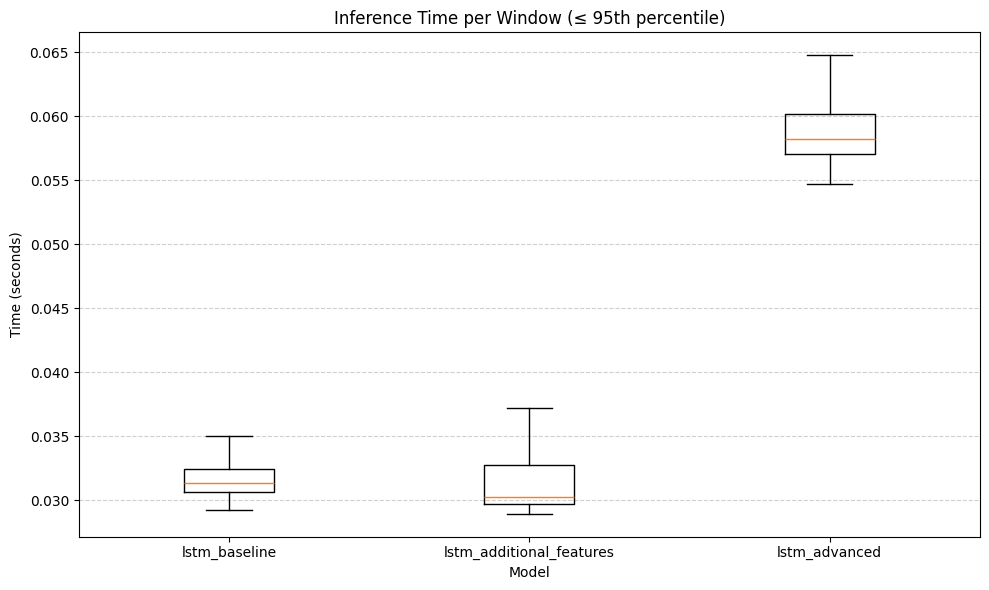

In [ ]:
# Create a dictionary of DataFrames for each model
val_dfs = {
    'lstm_baseline': val_df_lstm_baseline,
    'lstm_additional_features': val_df_lstm_features,
    'lstm_advanced': val_df_lstm_advanced
}

util.plot_side_by_side_inference_boxplots(val_dfs,
                                     inference_col='inference_time',
                                     percentile=95)

## Out of Sample Evaluation

### Highly Correlated Stocks: ID-104919

In [68]:
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

df_high_cor_stock = combined_df[combined_df["stock_id"] == 104919].copy()

snapshot_features_df_high_cor = util.create_snapshot_features(df_high_cor_stock)
snapshot_features_df_high_cor = snapshot_features_df_high_cor.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids = snapshot_features_df_high_cor['time_id'].unique()[:10]
subset_snapshot_df_high_cor = snapshot_features_df[snapshot_features_df_high_cor['time_id'].isin(subset_time_ids)].copy()

In [69]:
model_path  = 'out/lstm/advanced.h5'
scaler_path = 'out/lstm/advanced_scalers.pkl'

basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore",
                  "volume_imbalance"]

val_df_oos_high_cor, oos_metrics_high_cor = util.out_of_sample_evaluation(
    model_path, scaler_path,
    subset_snapshot_df_high_cor,
    feature_cols=basic_features
)

print("Out-of-Sample Metrics:", oos_metrics_high_cor)
print(val_df_oos_high_cor.head())


Out-of-Sample Metrics: {'mse': 3.276007473664776e-08, 'rmse': 0.00018099744400584158, 'qlike': 4.183757792128442, 'directional_accuracy': 0.519361833952912, 'avg_inference_time': 0.06196931018536619}
   time_id  start_time    y_true    y_pred  inference_time
0        6      1800.0  0.000185  0.000106        0.398865
1        6      1802.0  0.000129  0.000106        0.063055
2        6      1805.0  0.000329  0.000106        0.062352
3        6      1807.0  0.000446  0.000105        0.062805
4        6      1810.0  0.000438  0.000106        0.058524


### Lowly Correlated Stocks: ID-22753

In [70]:
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

df_low_cor_stock = combined_df[combined_df["stock_id"] == 22753].copy()

snapshot_features_df_low_cor = util.create_snapshot_features(df_low_cor_stock)
snapshot_features_df_low_cor = snapshot_features_df_low_cor.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids = snapshot_features_df_low_cor['time_id'].unique()[:10]
subset_snapshot_df_low_cor = snapshot_features_df_low_cor[snapshot_features_df_low_cor['time_id'].isin(subset_time_ids)].copy()

In [71]:
model_path  = 'out/lstm/advanced.h5'
scaler_path = 'out/lstm/advanced_scalers.pkl'
basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore",
                  "volume_imbalance"]

val_df_oos_low_cor, oos_metrics_low_cor = util.out_of_sample_evaluation(
    model_path, scaler_path,
    subset_snapshot_df_low_cor,
    feature_cols=basic_features
)

print("Out-of-Sample Metrics:", oos_metrics_low_cor)
print(val_df_oos_low_cor.head())

Out-of-Sample Metrics: {'mse': 3.320566820245771e-08, 'rmse': 0.00018222422507026257, 'qlike': 4.236690438652568, 'directional_accuracy': 0.5194151096669375, 'avg_inference_time': 0.0564814600901018}
   time_id  start_time    y_true    y_pred  inference_time
0        6      1800.0  0.000185  0.000106        0.338168
1        6      1802.0  0.000129  0.000106        0.056722
2        6      1805.0  0.000329  0.000106        0.056631
3        6      1807.0  0.000446  0.000105        0.056182
4        6      1810.0  0.000438  0.000106        0.056672


In [72]:
import pandas as pd

insample_adv = metric_df.loc[metric_df['model'] == 'lstm_advanced'].iloc[0].to_dict()

comparison_df = pd.DataFrame([
    {'dataset': 'in_sample',             **insample_adv},
    {'dataset': 'out_sample_highcor',   **oos_metrics_high_cor},
    {'dataset': 'out_sample_lowcor',    **oos_metrics_low_cor},
]).set_index('dataset')

display(comparison_df)


,model,mse,rmse,qlike,directional_accuracy,avg_inference_time
dataset,,,,,,
in_sample,lstm_advanced,2.566615e-09,0.000051,0.501960,0.469907,0.061351
out_sample_highcor,NaN,3.276007e-08,0.000181,4.183758,0.519362,0.061969
out_sample_lowcor,NaN,3.320567e-08,0.000182,4.236690,0.519415,0.056481
